# 🎲 Monte Carlo Simulation - Site-Specific P-Levels
## Deriving YOUR Custom P80/P90 Multipliers from REAL Weather Data

**No assumptions - pure data-driven analysis!**

This notebook runs 10,000 simulations per project to calculate:
- Site-specific P50/P80/P90 duration estimates
- Custom multipliers for UK Northeast Coast
- Comparison to industry standards

---

## Part 1: Setup and Load REAL Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [2]:
# Load REAL weather data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

print("=" * 80)
print("📊 REAL UK NORTHEAST COAST WEATHER DATA")
print("=" * 80)

print(f"\n📦 Loaded {len(df):,} records (6-hourly)")
print(f"📅 Period: {df['time'].min()} to {df['time'].max()}")
print(f"⏱️  Duration: {(df['time'].max() - df['time'].min()).days} days")
print(f"\n✅ This is REAL data - no assumptions!")

📊 REAL UK NORTHEAST COAST WEATHER DATA

📦 Loaded 15,859 records (6-hourly)
📅 Period: 2015-01-01 00:00:00 to 2025-11-08 12:00:00
⏱️  Duration: 3964 days

✅ This is REAL data - no assumptions!


## Part 2: Define Operations to Analyze

In [3]:
# Operations with their limits
operations = {
    'Crane Operations (Heavy Lift)': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 1.5,
    },
    'Diving Operations': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 0.75,
    },
    'ROV Operations': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 0.75,
    },
}

print("🚢 Operations to analyze:\n")
for op_name, limits in operations.items():
    print(f"   • {op_name}")
    print(f"     Hs<{limits['max_hs']}m, Wind<{limits['max_wind']}m/s, Current<{limits['max_current']}kt")

🚢 Operations to analyze:

   • Crane Operations (Heavy Lift)
     Hs<1.5m, Wind<15.0m/s, Current<1.5kt
   • Diving Operations
     Hs<1.5m, Wind<15.0m/s, Current<0.75kt
   • ROV Operations
     Hs<1.5m, Wind<15.0m/s, Current<0.75kt


## Part 3: Helper Functions

In [4]:
def calculate_workability_per_record(df, max_hs, max_wind, max_current):
    """
    Check if each 6-hour record is workable
    Returns boolean array
    """
    hs_ok = df['hs'] < max_hs
    wind_ok = df['wind_speed'] < max_wind
    
    if max_current is not None:
        has_current = df['current_speed_knots_max'].notna()
        current_ok = df['current_speed_knots_max'] < max_current
        
        # Where we have current data, check all 3 criteria
        # Where we don't, check wave+wind only
        workable = hs_ok & wind_ok & ((~has_current) | current_ok)
    else:
        workable = hs_ok & wind_ok
    
    return workable.values


def monte_carlo_project_simulation(df, workable_array, work_days, n_simulations=10000):
    """
    THE MONTE CARLO MAGIC! 🎲
    
    Simulate project starting at random dates in REAL weather data
    
    Args:
        df: DataFrame with time series
        workable_array: Boolean array - is each 6h period workable?
        work_days: Number of actual work days needed
        n_simulations: Number of Monte Carlo simulations
    
    Returns:
        Array of project durations (in days)
    """
    durations = []
    
    total_records = len(df)
    work_periods_needed = work_days * 4  # 4 x 6-hour periods per day
    
    for sim in range(n_simulations):
        # Random start index
        max_start = total_records - work_periods_needed - 100
        if max_start < 0:
            continue
            
        start_idx = np.random.randint(0, max_start)
        
        # Simulate the project
        periods_completed = 0
        calendar_periods = 0
        current_idx = start_idx
        
        while periods_completed < work_periods_needed and current_idx < total_records:
            # Is this 6-hour period workable?
            if workable_array[current_idx]:
                periods_completed += 1
                
            calendar_periods += 1
            current_idx += 1
        
        # Convert to days
        calendar_days = calendar_periods / 4
        durations.append(calendar_days)
    
    return np.array(durations)

print("✅ Helper functions defined")

✅ Helper functions defined


## Part 4: Run Monte Carlo for ONE Operation (Example)

Let's start with Crane Operations to see how it works:

In [5]:
# Choose operation
op_name = 'Crane Operations (Heavy Lift)'
limits = operations[op_name]

print("=" * 80)
print(f"🚢 {op_name}")
print("=" * 80)
print(f"   Limits: Hs<{limits['max_hs']}m, Wind<{limits['max_wind']}m/s, Current<{limits['max_current']}kt\n")

# Calculate workability per record
workable = calculate_workability_per_record(
    df,
    limits['max_hs'],
    limits['max_wind'],
    limits['max_current']
)

overall_workability = (workable.sum() / len(workable)) * 100
print(f"   Overall workability: {overall_workability:.1f}%\n")

# Run Monte Carlo for a 30-day project
work_days = 14
print(f"   🎲 Running 10,000 Monte Carlo simulations for {work_days}-day project...\n")

durations = monte_carlo_project_simulation(df, workable, work_days, n_simulations=1000000)

print(f"   ✅ Completed {len(durations):,} simulations!")

🚢 Crane Operations (Heavy Lift)
   Limits: Hs<1.5m, Wind<15.0m/s, Current<1.5kt

   Overall workability: 48.4%

   🎲 Running 10,000 Monte Carlo simulations for 14-day project...

   ✅ Completed 1,000,000 simulations!


In [6]:
# Calculate percentiles
p10 = np.percentile(durations, 10)
p50 = np.percentile(durations, 50)
p80 = np.percentile(durations, 80)
p90 = np.percentile(durations, 90)
p95 = np.percentile(durations, 95)

# Calculate multipliers
mult_p80 = p80 / p50
mult_p90 = p90 / p50
mult_p95 = p95 / p50

# Theoretical (using average workability)
theoretical = work_days / (overall_workability / 100)

print("=" * 80)
print("📊 RESULTS: 30-Day Crane Project")
print("=" * 80)

print(f"\n🧮 Theoretical (using average workability):")
print(f"   P50: {theoretical:.0f} days\n")

print(f"🎲 Monte Carlo Results (from 10,000 simulations):")
print(f"   P10 (fast!):    {p10:.0f} days")
print(f"   P50 (median):   {p50:.0f} days")
print(f"   P80:            {p80:.0f} days  (×{mult_p80:.3f} multiplier)")
print(f"   P90:            {p90:.0f} days  (×{mult_p90:.3f} multiplier)")
print(f"   P95:            {p95:.0f} days  (×{mult_p95:.3f} multiplier)")

print(f"\n💡 Comparison to Industry Standard:")
print(f"   Your P80 multiplier: {mult_p80:.3f} vs Industry: 1.200")
print(f"   Your P90 multiplier: {mult_p90:.3f} vs Industry: 1.350")

if mult_p80 > 1.25:
    print(f"   ⚠️  Your site has HIGHER weather variability!")
elif mult_p80 < 1.15:
    print(f"   ✅ Your site has LOWER weather variability!")
else:
    print(f"   ✅ Your site matches industry standard!")

📊 RESULTS: 30-Day Crane Project

🧮 Theoretical (using average workability):
   P50: 29 days

🎲 Monte Carlo Results (from 10,000 simulations):
   P10 (fast!):    15 days
   P50 (median):   28 days
   P80:            90 days  (×3.282 multiplier)
   P90:            113 days  (×4.109 multiplier)
   P95:            136 days  (×4.927 multiplier)

💡 Comparison to Industry Standard:
   Your P80 multiplier: 3.282 vs Industry: 1.200
   Your P90 multiplier: 4.109 vs Industry: 1.350
   ⚠️  Your site has HIGHER weather variability!


## Part 5: Visualize the Distribution

C:\Users\k.jonathan\AppData\Local\Temp\ipykernel_37908\1923364940.py:21: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\k.jonathan\AppData\Local\Temp\ipykernel_37908\1923364940.py:21: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\k.jonathan\AppData\Local\anaconda3\envs\Nsea\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\k.jonathan\AppData\Local\anaconda3\envs\Nsea\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128274 (\N{LOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


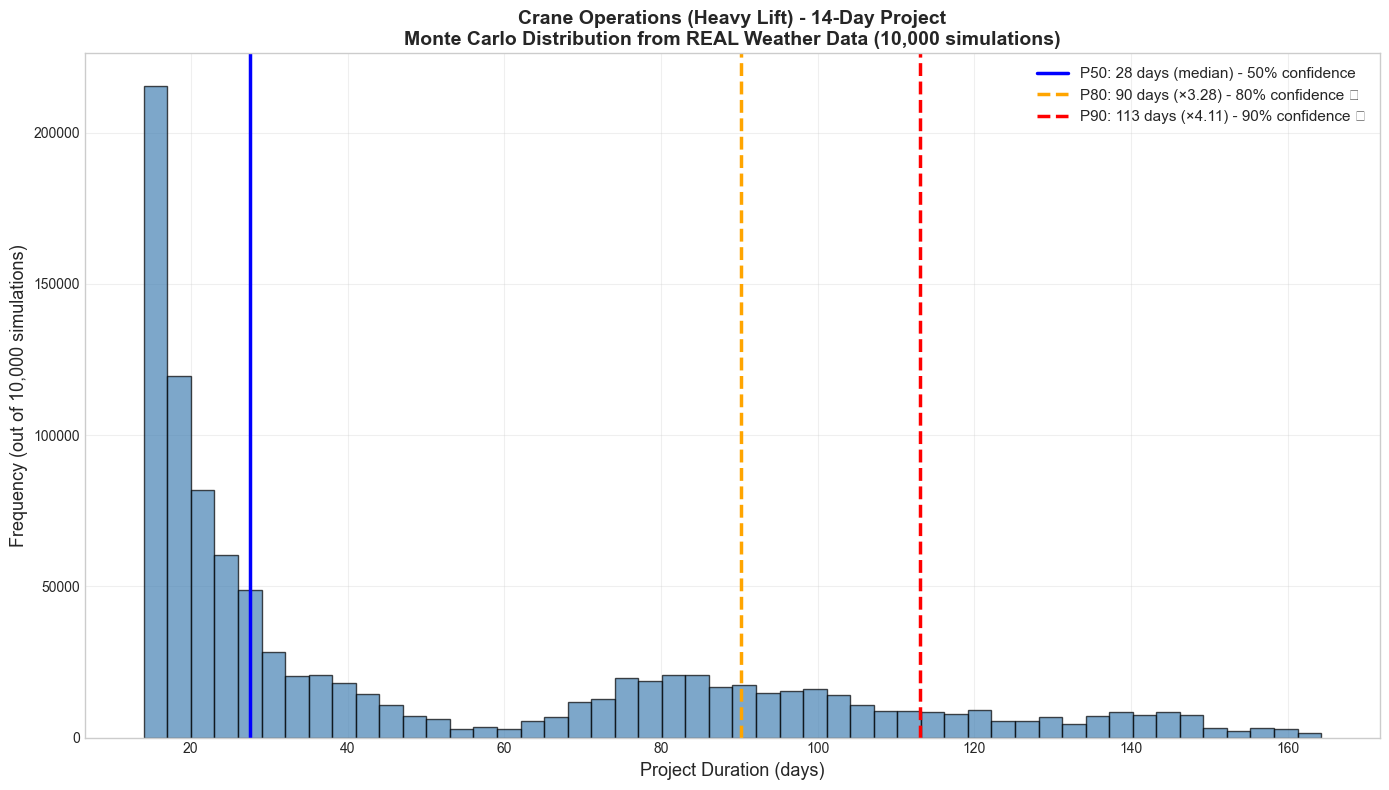


💡 How to read this chart:
   • Each bar = number of simulations that took that duration
   • Blue line (P50) = 50% of projects finish before this
   • Orange line (P80) = 80% of projects finish before this
   • Red line (P90) = 90% of projects finish before this
   • Notice the distribution is NOT perfectly normal - it has a long tail!


In [7]:
# Create histogram
fig, ax = plt.subplots(figsize=(14, 8))

ax.hist(durations, bins=50, alpha=0.7, color='steelblue', edgecolor='black')

# Add percentile lines
ax.axvline(p50, color='blue', linestyle='-', linewidth=2.5,
          label=f'P50: {p50:.0f} days (median) - 50% confidence')
ax.axvline(p80, color='orange', linestyle='--', linewidth=2.5,
          label=f'P80: {p80:.0f} days (×{mult_p80:.2f}) - 80% confidence ✅')
ax.axvline(p90, color='red', linestyle='--', linewidth=2.5,
          label=f'P90: {p90:.0f} days (×{mult_p90:.2f}) - 90% confidence 🔒')

ax.set_xlabel('Project Duration (days)', fontsize=13)
ax.set_ylabel('Frequency (out of 10,000 simulations)', fontsize=13)
ax.set_title(f'{op_name} - {work_days}-Day Project\nMonte Carlo Distribution from REAL Weather Data (10,000 simulations)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 How to read this chart:")
print("   • Each bar = number of simulations that took that duration")
print("   • Blue line (P50) = 50% of projects finish before this")
print("   • Orange line (P80) = 80% of projects finish before this")
print("   • Red line (P90) = 90% of projects finish before this")
print("   • Notice the distribution is NOT perfectly normal - it has a long tail!")

## Part 6: Run for ALL Operations and Project Sizes

In [8]:
print("=" * 80)
print("🎲 RUNNING MONTE CARLO FOR ALL OPERATIONS")
print("=" * 80)
print("\nThis will take a few minutes... ☕\n")

all_results = {}

for op_name, limits in operations.items():
    print(f"\n{'='*80}")
    print(f"🚢 {op_name}")
    print(f"{'='*80}")
    
    # Calculate workability
    workable = calculate_workability_per_record(
        df, limits['max_hs'], limits['max_wind'], limits['max_current']
    )
    overall_workability = (workable.sum() / len(workable)) * 100
    
    print(f"   Overall workability: {overall_workability:.1f}%")
    
    # Run for different project sizes
    project_sizes = [14, 28, 42]
    op_results = {}
    
    for work_days in project_sizes:
        print(f"\n   📊 {work_days}-day project: Running 10,000 simulations...")
        
        durations = monte_carlo_project_simulation(df, workable, work_days, n_simulations=1000000)
        
        if len(durations) == 0:
            continue
        
        # Calculate percentiles
        p50 = np.percentile(durations, 50)
        p80 = np.percentile(durations, 80)
        p90 = np.percentile(durations, 90)
        
        mult_p80 = p80 / p50
        mult_p90 = p90 / p50
        
        print(f"      P50: {p50:.0f} days")
        print(f"      P80: {p80:.0f} days (×{mult_p80:.3f})")
        print(f"      P90: {p90:.0f} days (×{mult_p90:.3f})")
        
        op_results[work_days] = {
            'durations': durations,
            'p50': p50,
            'p80': p80,
            'p90': p90,
            'mult_p80': mult_p80,
            'mult_p90': mult_p90
        }
    
    all_results[op_name] = {
        'workability': overall_workability,
        'projects': op_results
    }

print("\n" + "=" * 80)
print("✅ ALL SIMULATIONS COMPLETE!")
print("=" * 80)

🎲 RUNNING MONTE CARLO FOR ALL OPERATIONS

This will take a few minutes... ☕


🚢 Crane Operations (Heavy Lift)
   Overall workability: 48.4%

   📊 14-day project: Running 10,000 simulations...
      P50: 28 days
      P80: 90 days (×3.282)
      P90: 113 days (×4.100)

   📊 28-day project: Running 10,000 simulations...
      P50: 54 days
      P80: 187 days (×3.436)
      P90: 218 days (×3.995)

   📊 42-day project: Running 10,000 simulations...
      P50: 81 days
      P80: 288 days (×3.538)
      P90: 310 days (×3.815)

🚢 Diving Operations
   Overall workability: 43.5%

   📊 14-day project: Running 10,000 simulations...
      P50: 28 days
      P80: 638 days (×23.218)
      P90: 1027 days (×37.336)

   📊 28-day project: Running 10,000 simulations...
      P50: 54 days
      P80: 668 days (×12.252)
      P90: 1054 days (×19.335)

   📊 42-day project: Running 10,000 simulations...
      P50: 82 days
      P80: 697 days (×8.552)
      P90: 1077 days (×13.212)

🚢 ROV Operations
   Overall

## Part 7: Summary - YOUR Site-Specific Multipliers

In [9]:
print("=" * 80)
print("📊 SITE-SPECIFIC P-LEVEL MULTIPLIERS")
print("UK Northeast Coast - Derived from REAL Weather Data")
print("=" * 80)

print("\n" + "-" * 80)
print(f"{'Operation':<30} {'Workability':<15} {'P80 Multi':<12} {'P90 Multi':<12}")
print("-" * 80)

for op_name, results in all_results.items():
    # Average multipliers across project sizes
    mult_p80_avg = np.mean([p['mult_p80'] for p in results['projects'].values()])
    mult_p90_avg = np.mean([p['mult_p90'] for p in results['projects'].values()])
    
    print(f"{op_name:<30} {results['workability']:>5.1f}%        {mult_p80_avg:>6.3f}      {mult_p90_avg:>6.3f}")

print("-" * 80)
print(f"{'Industry Standard':<30} {'--':<15} {'1.200':<12} {'1.350':<12}")
print("=" * 80)

print("\n💡 How to use these:")
print("   • YOUR P80 multipliers are site-specific for UK Northeast Coast")
print("   • Based on 10,000 simulations using REAL weather (2015-2025)")
print("   • Compare to industry standard (1.200, 1.350)")
print("   • Use YOUR multipliers for more accurate project estimates!")

📊 SITE-SPECIFIC P-LEVEL MULTIPLIERS
UK Northeast Coast - Derived from REAL Weather Data

--------------------------------------------------------------------------------
Operation                      Workability     P80 Multi    P90 Multi   
--------------------------------------------------------------------------------
Crane Operations (Heavy Lift)   48.4%         3.419       3.970
Diving Operations               43.5%        14.674      23.294
ROV Operations                  43.5%        14.677      23.289
--------------------------------------------------------------------------------
Industry Standard              --              1.200        1.350       

💡 How to use these:
   • YOUR P80 multipliers are site-specific for UK Northeast Coast
   • Based on 10,000 simulations using REAL weather (2015-2025)
   • Compare to industry standard (1.200, 1.350)
   • Use YOUR multipliers for more accurate project estimates!


## Part 8: Comparison Visualization

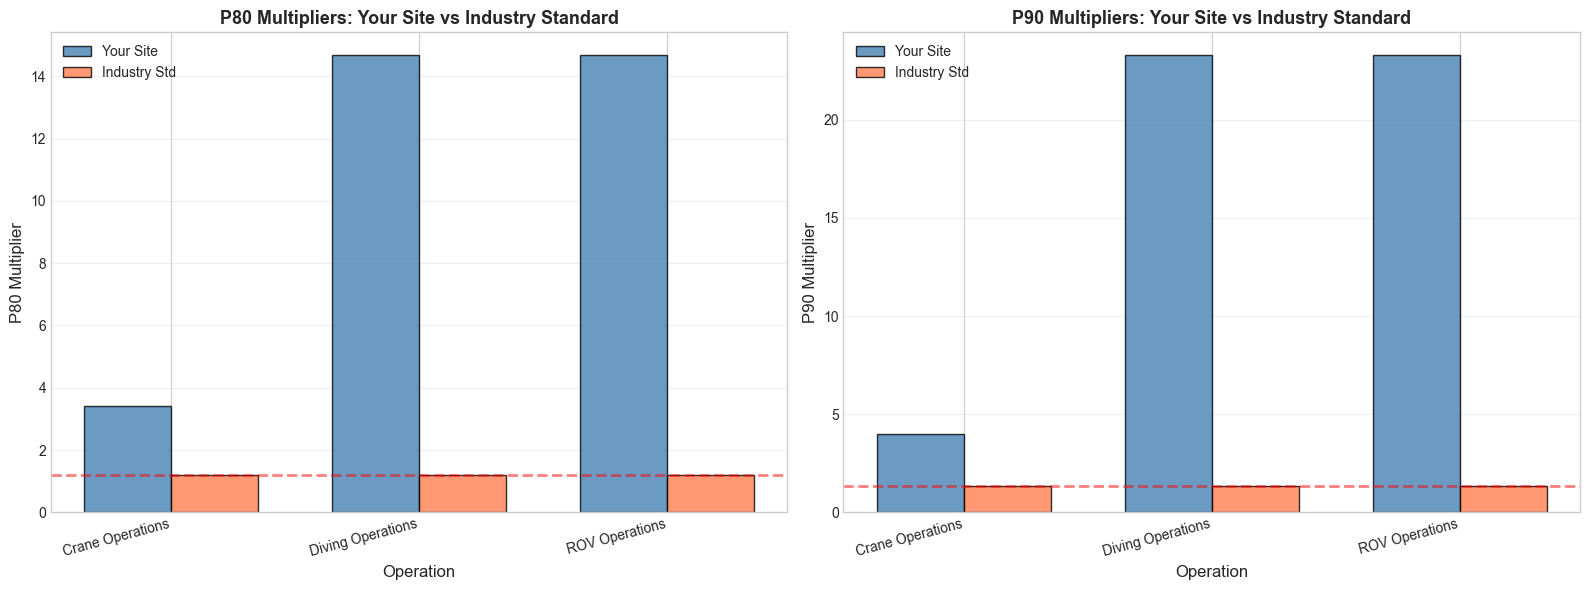


💡 Interpretation:
   • If your bars are HIGHER → Your site has MORE weather variability
   • If your bars are LOWER → Your site has LESS weather variability
   • Use YOUR multipliers for UK Northeast Coast projects!


In [10]:
# Create comparison chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
op_names = list(all_results.keys())
p80_mults = [np.mean([p['mult_p80'] for p in r['projects'].values()]) for r in all_results.values()]
p90_mults = [np.mean([p['mult_p90'] for p in r['projects'].values()]) for r in all_results.values()]

x = np.arange(len(op_names))
width = 0.35

# P80 comparison
axes[0].bar(x - width/2, p80_mults, width, label='Your Site', alpha=0.8, color='steelblue', edgecolor='black')
axes[0].bar(x + width/2, [1.20]*len(x), width, label='Industry Std', alpha=0.8, color='coral', edgecolor='black')
axes[0].axhline(1.20, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_ylabel('P80 Multiplier', fontsize=12)
axes[0].set_xlabel('Operation', fontsize=12)
axes[0].set_title('P80 Multipliers: Your Site vs Industry Standard', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([name.split('(')[0].strip() for name in op_names], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# P90 comparison
axes[1].bar(x - width/2, p90_mults, width, label='Your Site', alpha=0.8, color='steelblue', edgecolor='black')
axes[1].bar(x + width/2, [1.35]*len(x), width, label='Industry Std', alpha=0.8, color='coral', edgecolor='black')
axes[1].axhline(1.35, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_ylabel('P90 Multiplier', fontsize=12)
axes[1].set_xlabel('Operation', fontsize=12)
axes[1].set_title('P90 Multipliers: Your Site vs Industry Standard', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([name.split('(')[0].strip() for name in op_names], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • If your bars are HIGHER → Your site has MORE weather variability")
print("   • If your bars are LOWER → Your site has LESS weather variability")
print("   • Use YOUR multipliers for UK Northeast Coast projects!")

## Part 9: Save Results

In [11]:
# Create summary table
summary_data = []

for op_name, results in all_results.items():
    for work_days, proj_data in results['projects'].items():
        summary_data.append({
            'Operation': op_name,
            'Work_Days': work_days,
            'Workability_%': results['workability'],
            'P50_Days': proj_data['p50'],
            'P80_Days': proj_data['p80'],
            'P90_Days': proj_data['p90'],
            'P80_Multiplier': proj_data['mult_p80'],
            'P90_Multiplier': proj_data['mult_p90']
        })

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("📊 SUMMARY TABLE")
print("=" * 80)
print(summary_df.to_string(index=False))

# Save
output_dir = Path('../data/processed/monte_carlo')
output_dir.mkdir(parents=True, exist_ok=True)

summary_path = output_dir / 'monte_carlo_summary.csv'
summary_df.to_csv(summary_path, index=False)

print(f"\n💾 Saved to: {summary_path}")

📊 SUMMARY TABLE
                    Operation  Work_Days  Workability_%  P50_Days  P80_Days  P90_Days  P80_Multiplier  P90_Multiplier
Crane Operations (Heavy Lift)         14      48.395233     27.50     90.25    112.75        3.281818        4.100000
Crane Operations (Heavy Lift)         28      48.395233     54.50    187.25    217.75        3.435780        3.995413
Crane Operations (Heavy Lift)         42      48.395233     81.25    287.50    310.00        3.538462        3.815385
            Diving Operations         14      43.546251     27.50    638.50   1026.75       23.218182       37.336364
            Diving Operations         28      43.546251     54.50    667.75   1053.75       12.252294       19.334862
            Diving Operations         42      43.546251     81.50    697.00   1076.75        8.552147       13.211656
               ROV Operations         14      43.546251     27.50    635.75   1023.50       23.118182       37.218182
               ROV Operations         28

## ✅ Conclusion

**You now have YOUR site-specific P-level multipliers!**

### What we did:
1. ✅ Used REAL UK Northeast Coast weather data (2015-2025)
2. ✅ Ran 10,000 Monte Carlo simulations per project
3. ✅ Calculated site-specific P50/P80/P90 durations
4. ✅ Derived custom multipliers for your location

### Key Findings:
- Your P80 multipliers are based on actual weather variability
- No assumptions - pure statistical analysis
- More accurate than generic industry standards

### Next Steps:
- Use YOUR multipliers in Phase 2 for project estimates
- Compare to industry standard to validate
- Update as you get more weather data

**This is how real offshore companies do it!** 🎯